# Connectivity
**V.0.1 - Alpha testing, [contributions](#contributions)**

Traditional multivariate fMRI techniques focus on the information present in patterns of activity in localized regions (ROIs or searchlights). Functional connectivity measures help examine information that may be present across two brain regions, focusing on network interaction rather than spatial localization. When performing connectivity analyses, BOLD timeseries are compared across regions (usually with correlation) and the strength of the connection determines their functional connectivity. By including or excluding stimulus/task variables, we can study the modulation of connectivity by different cognitive states.

We are going to cover connectivity analysis over the next couple exercises, starting today with more basic ROI-level task-based and background connectivity and continuing after break with whole-brain connectivity analyses.  
             
For this script we will use a spatial attention dataset from Hutchinson et al. (in prep) that has been preprocessed with motion correction and linear detrending.

## Goal of this script
>Learn how to run seed-based connectivity analyses.  
>Learn to use an atlas to define seeds.  
>Learn about how stimulus responses impact connectivity.


## Table of Contents
[1. Data handling](#data_handling)  
[2. Mask the data](#mask)  
[3. Create a spherical ROI](#ROI_sphere)  
[4. Correlation matrix](#correlation_matrix)  
[5. Creating a seed from an atlas](#ROI_atlas)  
[6. Compute connectivity across parcels](#parcel_corr)  
[7. Background connectivity](#back_conn)  

### Exercises:  
>[Exercise 1](#ex1)  
>[Exercise 2](#ex2)    
>[Exercise 3](#ex3)  
>[Exercise 4](#ex4)  
>[Exercise 5](#ex5)  
>[Exercise 6](#ex6)  
>[Exercise 7](#ex7)  
>[Exercise 8](#ex8)  
>[Exercise 9](#ex9)  
>[Novel contribution](#novel) 

In [5]:
import nibabel as nib
import numpy as np
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from nilearn import plotting
from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure
from scipy import stats
from scipy.ndimage.measurements import center_of_mass
import matplotlib.pyplot as plt
import pandas as pd
import brainiak.utils.fmrisim as sim
from brainiak.fcma.util import compute_correlation
from nilearn import input_data
import time
%matplotlib inline

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 1. Data handling <a id="data_handling"></a>

The dataset we will be using was collected as part of a recently published study ([Hutchinson et al., 2016, JoCN](https://www.ncbi.nlm.nih.gov/pubmed/26439270)). A paper reporting the application of connectivity analyses to this dataset is being prepared for journal submission. Below find the README file describing the dataset.

In [6]:
# Where are the data stored
dir='/opt/public_FMRI/latatt/'

**Self-Study:** Explore the data

**Exercise 1**:<a id="ex1"></a> Carefully read the README file in dir. What are two differences between bg_image and raw_hires?

**A:**

In this dataset, participants attend to a stimulus on either the left or right side of the visual field. We will examine how such spatial attention impacts functional connectivity.

As with previous datasets, let's prepare the preprocessed data for analysis, here of subject #1.

In [6]:
# Where is the data found
dir_time = dir + 'onsets/fsl'  
dir_motion = dir + 'processed_data/motionnuisance/'
dir_motion_global = dir + 'processed_data/motionnuisanceglobal/'

sub = 'sub1'
num_runs = 1
TR = 1.5
scan_duration = 540

# Shift the data a certain amount
shift_size = 0

We are going to set up a function to allow us to shift the labels to take into consideration the hemodynamic lag. However, we are not actually going to shift the labels here because we care about the build-up in hemodynamic activity which is lost if we implement a lag.

In [7]:
# Create a function to shift the labels
def shift_timing(label_TR, TR_shift_size):
    
    # Create a short vector of extra zeros
    zero_shift = np.zeros((TR_shift_size, 1))

    # Zero pad the column from the top.
    label_TR_shifted = np.vstack((zero_shift, label_TR))

    # Don't include the last rows that have been shifted out of the time line.
    label_TR_shifted = label_TR_shifted[0:label_TR.shape[0],0]
    
    return label_TR_shifted

We need to retrieve the labels from the FSL onsets file. [The function for doing this](http://brainiak.org/docs/brainiak.utils.html#brainiak.utils.fmrisim.generate_stimfunction)
is already defined in BrainIAK. To set up the data appropriately, we first call BrainIAKs "generate_stimfunction" function, then we use the "shift_timing" function that we defined above.

**Self-study:** What does generate_stimfunction do?

In [8]:
# Use the utilities from the simulator to create an event time course based on an FSL onset file

right_stimfunction = sim.generate_stimfunction(onsets='', 
                                               event_durations='', 
                                               total_time=scan_duration,
                                               temporal_resolution=1/TR, 
                                               timing_file=(dir_time + '/%s/right.txt' % (sub)),
                                               )

left_stimfunction  = sim.generate_stimfunction(onsets='', 
                                               event_durations='', 
                                               total_time=scan_duration,
                                               temporal_resolution=1/TR, 
                                               timing_file=(dir_time + '/%s/left.txt' % (sub)),
                                               )

# Shift the timecourses to account for the hemodynamic lag
right_stim_lag = shift_timing(right_stimfunction, shift_size)
left_stim_lag = shift_timing(left_stimfunction, shift_size)

# Get the nifti object
nii = nib.load(dir_motion + '%s.nii.gz' % (sub))

This dataset has two conditions: attend left and attend right. Let's visualize their timecourse.

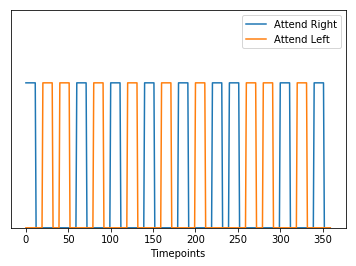

In [9]:
# Plot the stim time course. Assign the second stiumulus a different label (e.g. label =2)
plt.plot(right_stim_lag)
plt.plot(left_stim_lag)
plt.yticks([], '')
plt.xlabel('Timepoints')

plt.legend(('Attend Right', 'Attend Left'),
           loc='upper right')
plt.ylim(0, 1.5)
plt.show()

### 2.  Mask the data <a id="mask"></a>

Extract all voxels in the whole brain and all timepoints assigned to a condition using the [nilearn masking procedure](http://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMasker.html) and then z-score the data. Now let's take a first look at the data.

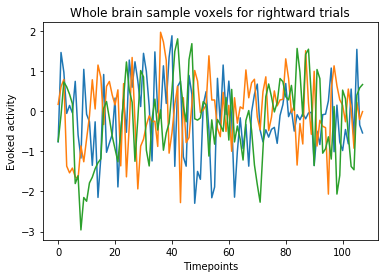

In [10]:
# Create a masker object that also standardizes the data
brain_masker = input_data.NiftiMasker(standardize=True,  # Are you going to zscore the data across time?
                                      t_r=1.5, 
                                      memory='nilearn_cache',  # Caches the mask in the directory given as a string here so that it is easier to load and retrieve
                                      memory_level=1,  # How much memory will you cache?
                                      verbose=0,
                                     )

# Pull out the time course for voxel
brain_time_series = brain_masker.fit_transform(nii)
boldWB_rightstim = brain_time_series[(right_stim_lag==1),:]

# Plot the timeseries for a few voxels
plt.title('Whole brain sample voxels for rightward trials');
plt.plot(boldWB_rightstim[:,[10, 100, 1000]]);
plt.ylabel('Evoked activity');
plt.xlabel('Timepoints');

### 3. Create a spherical ROI  <a id="ROI_sphere"></a>

Let's create an ROI to define the parahippocampal place area (PPA), a scene selective region, which is likely important since scene stimuli were presented. The data are currently in MNI space, a standardized anatomical space that allows us to compare individual anatomy to a common, averaged space and use coordinates in MNI space to identify regions (approximately) in individual participants.

**Exercise 2:**<a id="ex2"></a> [Neurosynth](http://neurosynth.org/) is an excellent resource for determining seeds and ROIs. Go to this website and report the peak coordinates for the two most significant clusters from the search term "Scenes" using reverse inference. We are going to use the peak from the left hemisphere, plug these coordinates into ppa_coords below. What is the difference between voxels that are above threshold for the "reverse inference" analysis compared to the "forward inference" analysis? 

**A:**

In [11]:
# Specify the center of the ROI
ppa_coords = [()]

Nilearn has some powerful tools for drawing ROIs. These functions allow you to flexibly identify ROIs of any shape and have multiple parameters that allow for smoothing, detrending, filtering and standardization. However, it is easy to get things wrong with these functions so use these parameters cautiously. We will play it safe and use the most basic sphere ROI using the [NiftiSpheresMasker function from nilearn](http://nilearn.github.io/modules/generated/nilearn.input_data.NiftiSpheresMasker.html).

In [12]:
# Create the masking object
seed_masker = input_data.NiftiSpheresMasker(ppa_coords, 
                                            radius=8,
                                            standardize=True,
                                            t_r=2.,
                                            memory='nilearn_cache', 
                                            memory_level=1, 
                                            verbose=0)

# Mask the epi data and get a time series for the ROI
seed_time_series = seed_masker.fit_transform(nii)

# Plot the data from the seed region for both attention condition
boldSeed_rightstim = seed_time_series[right_stim_lag == 1, :]
boldSeed_leftstim = seed_time_series[left_stim_lag == 1, :]
plt.title('Left PPA ROI activity for right and left attention conditions')
plt.plot(boldSeed_rightstim, 'b');
plt.plot(boldSeed_leftstim, 'r');
plt.legend(('right att', 'left att'));
plt.ylabel('Evoked activity');
plt.xlabel('Timepoints');

print("seed time series shape: (%s, %s)" % boldSeed_rightstim.shape)
print("brain time series shape: (%s, %s)" % boldWB_rightstim.shape)

ValueError: Seeds must be a list of triplets of coordinates in native space.
Seed #0 is of length 0 instead of 3.

### 4. Correlation matrix  <a id="correlation_matrix"></a>

We previously encountered correlation matrices in the exercise on pattern similarity. Each cell in those matrices corresponded to the spatial correlation of the pattern of activity for a pair of stimuli or tasks. We will again be using correlation matrices, but now for assessing functional connectivity. Each cell in these matrices reflects the correlation of the BOLD timeseries between a pair of voxels or regions, and matrices can be calculated separately for each condition or even each trial.

Below we go through a slow loop-based way of calculating the correlation of every voxel in the brain with the PPA seed region. We will revisit optimized ways of calculating correlations in the next exercise.

In [ ]:
# Correlate seed with every brain voxel. Loop through and extract data for every voxel.
start_time = time.time()
voxels = boldWB_rightstim.shape[1]
all_corr = np.zeros((voxels, 1))
for voxel_counter in range(voxels):    
    corr = np.corrcoef(boldSeed_rightstim[:,0], boldWB_rightstim[:, voxel_counter])[0, 1]
    all_corr[voxel_counter, 0] = corr

end_time = time.time()
print('Analysis duration for %d voxels: %0.2fs' % (voxels, (end_time - start_time)))

We are going to be calculating seed-based correlations throughout this notebook, so let's make a function. It is also common to transform the correlations to a Fisher-Z score, as the bounded nature of Pearson correlation violates certain statistical assumptions. This generally does not have a big effect on the results.

In [ ]:
def seed_correlation(wbBold, seedBold):
    voxels = wbBold.shape[1]
    seed_corr = np.zeros((voxels, 1))
    for voxel_counter in range(voxels):    
        seed_corr[voxel_counter, 0] = np.corrcoef(seedBold[:,0], wbBold[:, voxel_counter])[0, 1]
        
    # Transfrom the correlation values to Fisher z-scores    
    seed_corr_fishZ = np.arctanh(seed_corr)
    
    return seed_corr, seed_corr_fishZ

In [ ]:
# Let's use the function and print out the range of results
ppa_rtstim_corr, ppa_rtstim_corr_fz  = seed_correlation(boldWB_rightstim, boldSeed_rightstim)

print("seed-based correlation Fisher-z transformed: min = %.3f; max = %.3f" % (
    ppa_rtstim_corr_fz.min(),
    ppa_rtstim_corr_fz.max()))

# We can tranform the correlation array back to a Nifti image object that we can save
ppa_rtstim_corr_img = brain_masker.inverse_transform(ppa_rtstim_corr.T)
ppa_rtstim_corr_img.to_filename('seed_rtstim.nii.gz')

In [ ]:
# Let's also visualize the correlation of the seed with every voxel

# A histogram is always a useful first way of looking at your data.
plt.hist(ppa_rtstim_corr_fz)
plt.ylabel('Frequency');
plt.xlabel('Fisher-z score');

# Nilearn has useful tools for plotting our results as a map
h1 = plotting.plot_stat_map(ppa_rtstim_corr_img, 
                            threshold=0.5,
                            cut_coords=ppa_coords[0])

# Add the seed
h1.add_markers(marker_coords=ppa_coords, 
               marker_color='g',
               marker_size=50)

# Create a glass brain
plotting.plot_glass_brain(ppa_rtstim_corr_img, 
                          threshold=0.5,
                          colorbar=True, 
                          plot_abs=False)

**Exercise 3:**<a id="ex3"></a> Compute and plot the correlation with the left PPA when participants are attending to the scene in the left visual field.


In [ ]:
# Insert code here



**Exercise 4:**<a id="ex4"></a> Create a spherical ROI corresponding to the right PPA from Neurosynth. Compute correlations across the whole brain in both conditions and plot your results.

In [ ]:
# Insert code here


### 5. Creating a seed from an atlas  <a id="ROI_atlas"></a>

In addition to creating our own seed ROIs, we can use available atlases to extract ROIs and compare correlations. Nilearn provides an easy way to accomplish this. To summarize up front:
1. [Use Nilearn to import an atlas parcellation](http://nilearn.github.io/modules/reference.html#module-nilearn.datasets). This will download and save in your home directory by default. 
2. Explore the atlas: plot the different parcels and get their labels.
3. Choose one parcel as the seed and extract BOLD signal from our dataset.
4. Perform correlation.

In [ ]:
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = atlas.maps

# This is where the atlas is saved.
print("Atlas path: " + atlas_filename + "\n\n")

# Create a Pandas dataframe of the atlas data for easy inspection.
atlas_pd = pd.DataFrame(atlas)

# Plot the ROIs
plotting.plot_roi(atlas_filename);
print('Harvard-Oxford cortical atlas')

In [ ]:
# Print the labels
# Note that Label #35 is the Parahippocampal Gyrus, posterior division. Label 0 (Background) refers to the brain image, not background connectivity
print(atlas_pd['labels'])

In [ ]:
# Create a masker object that we can use to select ROIs
masker = NiftiLabelsMasker(labels_img=atlas_filename)
print(masker)

# Apply our atlas to the Nifti object so we can pull out data from single parcels/ROIs
parcel_time_series = masker.fit_transform(nii)

In previous analyses we calculated the average activity in a single seed region across time. However, Nilearn has tools to easily calculate the timecourse of activity across all of the ROIs that are supplied to the masker object.

In [ ]:
# Get data for rightward attention only
boldParcel_rightstim = parcel_time_series[(right_stim_lag==1),:]

# What does our data structure look like?
print("Parcellated dimensionality: %d timepoints by %d ROIs" % parcel_time_series.shape)
print("Parcellated dimensionality for rightward attention trials: %d timepoints by %d ROIs" % boldParcel_rightstim.shape)

# Pull out a single ROI corresponding to the posterior parahippocampal cortex
boldAtlasSeed_rightstim = np.array(boldParcel_rightstim[:, 35])
boldAtlasSeed_rightstim = boldAtlasSeed_rightstim.reshape(boldAtlasSeed_rightstim.shape[0],-1)
print("Dimensionality for posterior PPA (region 35) rightward attention trials: %d timepoints by %d ROIs" % boldAtlasSeed_rightstim.shape)
plt.figure()
plt.plot(boldAtlasSeed_rightstim)
plt.ylabel('Evoked activity');
plt.xlabel('Timepoints');

In [ ]:
# Like before we want to correlate the whole brain time course witht the seed we have pulled out
phg_corr_rtstim, phg_corr_rtstim_fz = seed_correlation(boldWB_rightstim, boldAtlasSeed_rightstim) 

# Save the nifti image
phg_corr_rtstim_fz_img = brain_masker.inverse_transform(
    phg_corr_rtstim_fz.T)
phg_corr_rtstim_fz_img.to_filename('sbc_z.nii.gz')

# Print the range of correlations.
print("PHG correlation Fisher-z transformed: min = %.3f; max = %.3f" % (
    phg_corr_rtstim_fz.min(),
    phg_corr_rtstim_fz.max()))

# Plot a histogram
plt.hist(phg_corr_rtstim_fz)
plt.ylabel('Frequency');
plt.xlabel('Fisher-z score');

# Plot the correlation as a map on a standard brain. 
# For comparison, we also plot the position of the sphere we created ealier.
h2 = plotting.plot_stat_map(phg_corr_rtstim_fz_img, 
                            threshold=0.5,
                            cut_coords=ppa_coords[0],
                           )

h2.add_markers(marker_coords=ppa_coords, 
               marker_color='g',
               marker_size=50)


### 6. Compute connectivity across parcels <a id="parcel_corr"></a>

In addition to one ROI, we can compute correlations across multiple brain regions. [Nilearn has a function](http://nilearn.github.io/modules/reference.html#module-nilearn.connectome) to do this quite easily.

In [ ]:
# Set up the connectivity object
correlation_measure = ConnectivityMeasure(kind='correlation')

# Calculate the correlation of each parcel with every other parcel
correlation_matrix = correlation_measure.fit_transform([boldParcel_rightstim])[0]

# Remove the diagonal for visualization (guaranteed to be 1.0)
np.fill_diagonal(correlation_matrix, np.nan)

# Plot the correlation matrix
# The labels of the Harvard-Oxford Cortical Atlas that we are using 
# start with the background (0), hence we skip the first label
fig=plt.figure(figsize=(9,8))
plt.imshow(correlation_matrix, interpolation='None')
plt.yticks(range(len(atlas.labels)), atlas.labels[1:]);
plt.xticks(range(len(atlas.labels)), atlas.labels[1:], rotation=90);
plt.title('Parcellation correlation matrix')
plt.colorbar()

# Alternatively, we could use Nilearn's own plotting function
plotting.plot_matrix(correlation_matrix, 
                     figure=(10, 8), 
                     labels=atlas.labels[1:],
                     vmax=1, 
                     vmin=0)

**Exercise 5:**<a id="ex5"></a> Use a parcel from the parietal lobe as a seed and compute the **voxelwise** correlation across the brain for the attend left and attend right conditions. Are there any connectivity differences between these conditions? Remember this is only one subject and so it is difficult to test this statistically. Use [`plotting.find_xyz_cut_coords`](http://nilearn.github.io/modules/generated/nilearn.plotting.find_xyz_cut_coords.html#nilearn.plotting.find_xyz_cut_coords) to find the center of the parcel and then use `cut_coords`  and `marker_coords` in your plotting function to center on the seed.

In [ ]:
# Insert code here


### 7. Background connectivity <a id="back_conn"></a>

Beyond functional connectivity that is driven by stimulus-related activation, you might also want to analyze background connectivity, to find out more about cognitive states that underlie a given task. To learn more about background connectivity, see this [review by Nicholas Turk-Browne (2013, Science)](https://doi.org/10.1126/science.1238409)
In background connectivity analysis, stimulus-driven activation is not the desired effect of interest, but a confound. Thus, now we need to remove "stimulus confounds" before continuing. Lucky for us, the dataset in the directory motionnuisanceglobal has already had the evoked activity regressed out in FSL with a GLM. We'll repeat the previous analyses for the left PPA on these data.

In [ ]:
# Load in the data
epi_in_mcg = (dir_motion_global + '%s.nii.gz' % (sub))
seed_time_series_mcg = seed_masker.fit_transform(epi_in_mcg)
boldSeed_rtstim_mcg = seed_time_series_mcg[right_stim_lag==1,:]
boldWB_mcg = brain_masker.fit_transform(epi_in_mcg)
boldWB_rtstim_mcg = boldWB_mcg[right_stim_lag==1,:] 

# plot the data
plt.plot(boldSeed_rtstim_mcg)
plt.ylabel('BOLD signal, standardized')
plt.xlabel('TRs of right attention blocks')
plt.title('Background activity in seed region')

In [ ]:
# Calculate the voxelwise seed-based correlation
ppa_corr_rtstim_mcg, ppa_corr_rtstim_fz_mcg  = seed_correlation(boldWB_rtstim_mcg, boldSeed_rtstim_mcg)

print("PHG correlation Fisher-z transformed: min = %.3f; max = %.3f" % (
    ppa_corr_rtstim_fz_mcg.min(),
    ppa_corr_rtstim_fz_mcg.max()))


# Plot the correlation of each voxel in the brain with the seed
ppa_corr_rtstim_mcg_img = brain_masker.inverse_transform(ppa_corr_rtstim_mcg.T)

h3 = plotting.plot_stat_map(ppa_corr_rtstim_mcg_img, 
                            threshold=0.5,
                            cut_coords=ppa_coords[0])

h3.add_markers(marker_coords=ppa_coords, 
               marker_color='g',
               marker_size=50)

plotting.plot_glass_brain(ppa_corr_rtstim_mcg_img, 
                          threshold=0.5,
                          colorbar=True, 
                          plot_abs=False)

**Exercise 6:**<a id="ex6"></a> Compare background connectivity to the original left PPA spherical ROI result. Why is there less and cleaner connectivity overall?

**A:**

In [ ]:
# Parcellate the time course to get the background connectivity parcels
parcel_time_series_mcg = masker.fit_transform(epi_in_mcg)
boldParcel_rightstim_mcg = parcel_time_series_mcg[right_stim_lag==1, :]

correlation_matrix_mcg = correlation_measure.fit_transform([boldParcel_rightstim_mcg])[0]

# Remove the diagonal for visualization (guaranteed to be 1.0)
np.fill_diagonal(correlation_matrix_mcg, np.nan)

# Plot the correlation matrix
fig=plt.figure(figsize=(9,8))

# The labels we have start with the background (0), hence we skip the first label
plt.title('Background connnectivity correlation for parcellation')
plt.imshow(correlation_matrix_mcg, interpolation='None')
plt.yticks(range(len(atlas.labels)), atlas.labels[1:]);
plt.xticks(range(len(atlas.labels)), atlas.labels[1:], rotation=90);
plt.colorbar()

**Exercise 7:**<a id="ex7"></a> Use a different atlas [(use `datasets.fetch\_`)](http://nilearn.github.io/modules/reference.html#module-nilearn.datasets) and look through other available atlases) and recompute the background connectivity matrix for both attend left and attend right conditions. Use an atlas that distinguishes ROIs between the left and right hemispheres and rearrange the labels so that all the ROIs from a hemisphere are grouped. Why might it be important to separate the hemispheres?

In [ ]:
# Insert code here


**Exercise 8:**<a id="ex8"></a> Calculate and store the two matrices above (one for each attention condition) for all 30 participants. Plot the average across participants for each condition.

In [ ]:
# Insert code here


**Exercise 9:**<a id="ex9"></a> For each participant, calculate the difference between their matrix for left attention and the matrix for right attention. You should now have 30 difference matrices. This allows you to conduct a simple statistical test of how reliably left vs. right attention affects background connectivity between parcels in the sample. We will use a one-sample t-test for this purpose, which requires two inputs: (1) the average difference matrix across participants and (2) the standard error of the difference matrix across participants (standard deviation matrix divided by root df). Compute and plot a t-statistic matrix by dividing the average difference matrix by the standard error matrix. Summarize in words which regions' connectivity (if any) distinguishes attention conditions.

In [ ]:
# Insert code here


**Plotting a connectome** 

Nilearn has some beautiful tools for plotting connectomes. [`plotting.plot_connectome`](http://nilearn.github.io/modules/generated/nilearn.plotting.plot_connectome.html) takes in the node by node correlation matrix and a node by coordinate matrix and then creates a connectome. Thresholds can be used to only show strong connections. 

**Self-study:** Building on the code below, play around with [`plotting.plot_connectome`](http://nilearn.github.io/modules/generated/nilearn.plotting.plot_connectome.html) to make it work.

In [ ]:
# Load the atlas
atlas_nii = nib.load(atlas_filename)
atlas_data = atlas_nii.get_data()
labels = np.unique(atlas_data)

# Iterate through all of the ROIs
coords = []
for label_id in labels:
    
    # Skip the background
    if label_id == 0:
        continue
        
    # Pull out the ROI of within the mask    
    roi_mask = (atlas_data == label_id)
    
    # Create as a nifti object so it can be read by the cut coords algorithm
    nii = nib.Nifti1Image(roi_mask.astype('int16'), atlas_nii.affine)
    
    # Find the centre of mass of the connectome
    coords.append(plotting.find_xyz_cut_coords(nii))
    
# Plot the connectome
plotting.plot_connectome(correlation_matrix_mcg, coords, edge_threshold='95%')

**Novel contribution:** <a id="novel"></a> be creative and make one new discovery by adding an analysis, visualization, or optimization.

## Contributions <a id="contributions"></a>

B. Hutchinson provided data and provided initial code  
M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook 3/15/18  